# Lucy in the sky with diamonds 

## Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import src.Cleaning_functions as fn
from scipy import stats
import math



from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


## Some info:

**Carat**: Diamond **carat** weight measures how much a diamond weighs. All else being equal, diamond price increases with diamond **carat** weight because larger diamonds are rarer and more desirable. However, two diamonds of equal carat weight can have very different values (and prices) depending on three other factors of the diamond 4Cs: **Color**, **Clarity**, and **Cut**.
   
 **Color**: D-to-Z diamond color-grading system measures the degree of colorlessness by comparing a stone. 
   
 **Cut**: Diamond’s cut grade is really about how well a diamond’s facets interact with light.
 
 **Clarity**: 
     + Flawless (FL) No inclusions and no blemishes visible under 10x magnification
     + Internally Flawless (IF) No inclusions visible under 10x magnification
     + Very, Very Slightly Included (VVS1 and VVS2) Inclusions so slight they are difficult for a skilled grader to see under 10x magnification
     + Very Slightly Included (VS1 and VS2) Inclusions are observed with effort under 10x magnification, but can be characterized as minor
     + Slightly Included (SI1 and SI2) Inclusions are noticeable under 10x magnification
     + Included (I1, I2, and I3) Inclusions are obvious under 10x magnification which may affect transparency and brilliance
     
**x**: length in mm

**y**: width in mm

**z**: depth in mm

**depth**: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

**table**: width of top of diamond relative to widest point (43--95)

*https://4cs.gia.edu/en-us/4cs-diamond-quality/*

## Explore the data

In [3]:
train = pd.read_csv('./INPUT/diamonds_train.csv') 
test = pd.read_csv('./INPUT/diamonds_test.csv')

In [4]:
train.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
0,0,1.21,Ideal,H,VS2,63.0,57.0,6.73,6.70,4.23,6134
1,1,0.28,Very Good,D,VVS2,64.0,56.0,4.14,4.17,2.66,532
2,2,0.42,Premium,F,VS1,61.2,58.0,4.86,4.82,2.96,1103
3,3,0.26,Ideal,H,IF,61.1,57.0,4.16,4.12,2.53,600
4,4,1.10,Good,G,SI1,63.4,57.0,6.52,6.55,4.14,4997


In [5]:
print(train.shape)
train.dtypes

(40345, 11)


Unnamed: 0      int64
carat         float64
cut            object
color          object
clarity        object
depth         float64
table         float64
x             float64
y             float64
z             float64
price           int64
dtype: object

In [6]:
train.describe(include='all')

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
count,40345.000000,40345.000000,40345,40345,40345,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000,40345.000000
unique,NaN,NaN,5,7,8,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Ideal,G,SI1,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,16090,8499,9751,NaN,NaN,NaN,NaN,NaN,NaN
mean,20172.000000,0.795652,NaN,NaN,NaN,61.750413,57.460302,5.726106,5.730217,3.535136,3924.089924
std,11646.742642,0.470806,NaN,NaN,NaN,1.424219,2.235333,1.118690,1.148584,0.693662,3982.000515
min,0.000000,0.200000,NaN,NaN,NaN,43.000000,43.000000,0.000000,0.000000,0.000000,326.000000
25%,10086.000000,0.400000,NaN,NaN,NaN,61.000000,56.000000,4.710000,4.720000,2.910000,948.000000
50%,20172.000000,0.700000,NaN,NaN,NaN,61.800000,57.000000,5.690000,5.710000,3.520000,2395.000000
75%,30258.000000,1.040000,NaN,NaN,NaN,62.500000,59.000000,6.540000,6.530000,4.030000,5313.000000


In [7]:
train.isnull().sum()

Unnamed: 0    0
carat         0
cut           0
color         0
clarity       0
depth         0
table         0
x             0
y             0
z             0
price         0
dtype: int64

In [8]:
train.columns

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x',
       'y', 'z', 'price'],
      dtype='object')

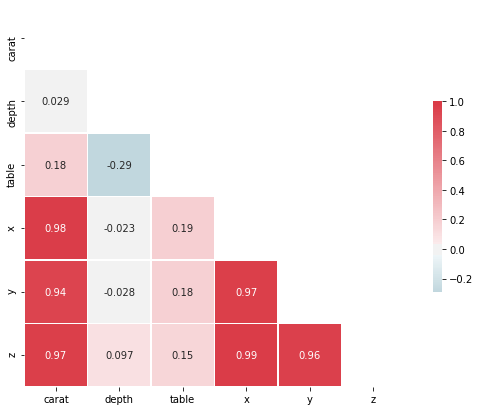

In [9]:
#Create the correlation matrix
correlation_matrix = train.drop(columns=['Unnamed: 0', 'price'], axis=1).corr()
#A mask to hide repeated data on top of the diagonal
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Draw the heatmap:
f, ax = plt.subplots(figsize=(10, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

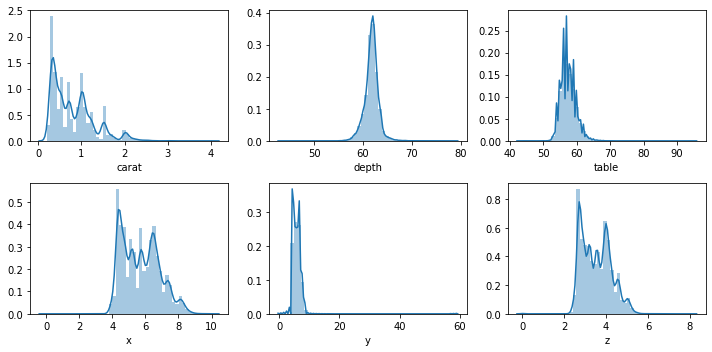

In [10]:
f, ax = plt.subplots(2,3, figsize=(10,5))
for i, e in enumerate(train.drop(columns=['Unnamed: 0','cut', 'color', 'clarity', 'price'], axis=1)):
    sns.distplot(train[e], ax = ax[(0 if i<3 else 1),(i if i<3 else i-3)])
plt.tight_layout()

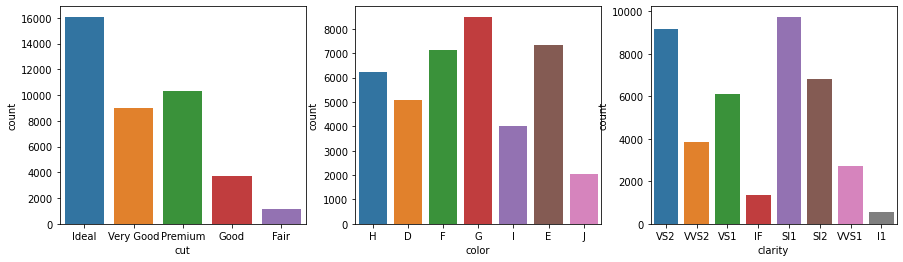

In [11]:
f, ax = plt.subplots(1,3, figsize = (15,4))
sns.countplot(train['cut'], ax = ax[0])
sns.countplot(train['color'], ax = ax[1])
sns.countplot(train['clarity'], ax = ax[2])

## Data Engineering

Converting object features into ordered numericals:

In [4]:
clarity = ('IF', 'VVS2','VS1','VS2','SI1','SI2','I1' )
color = ('J', 'I', 'H', 'G', 'F', 'E', 'D')
cut = ('Premium', 'Ideal', 'Very Good', 'Good','Fair')
categories = fn.categorize([train.cut, train.color, train.clarity], [cut, color, clarity])

In [5]:
train_clean = pd.concat([train.drop(['Unnamed: 0', 'cut', 'color', 'clarity'], axis= 1) , categories], axis=1, sort=False )
train_clean.head(3)

,carat,depth,table,x,y,z,price,cut_cat,color_cat,clarity_cat
0,1.21,63.0,57.0,6.73,6.70,4.23,6134,1,2,3
1,0.28,64.0,56.0,4.14,4.17,2.66,532,2,6,1
2,0.42,61.2,58.0,4.86,4.82,2.96,1103,0,4,2


Let's try now with dummy variables for the categories:

Remove outliers:

In [6]:
train_clean = train_clean[(np.abs(stats.zscore(train_clean)) < 3).all(axis=1)]


Remove unnecesary columns:

In [8]:
X_clean = train_clean.drop(['price'], axis= 1) 
y = train_clean.price

Transform the target:

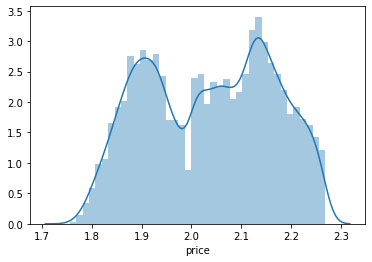

In [9]:
y = train_clean.price.apply(math.log)
sns.distplot(y.apply(math.log))

Standardize and normalize

In [10]:
pipeline = [
    StandardScaler(),
    Normalizer()
]

tr = make_pipeline(*pipeline)

X = tr.fit_transform(X_clean)
X = pd.DataFrame(X,columns=X_clean.columns)
X

,carat,depth,table,x,y,z,cut_cat,color_cat,clarity_cat
0,0.428370,0.394314,-0.070989,0.408754,0.398727,0.453551,-0.081889,-0.341455,0.030128
1,-0.294736,0.462922,-0.170394,-0.374072,-0.370065,-0.332895,0.212872,0.394886,-0.284348
2,-0.370266,-0.202588,0.138437,-0.348410,-0.370083,-0.378206,-0.567893,0.153222,-0.235215
3,-0.345924,-0.151634,-0.052097,-0.415826,-0.430904,-0.433622,-0.060096,-0.250585,-0.491537
4,0.275370,0.442395,-0.060299,0.279502,0.289995,0.338284,0.624669,-0.088807,0.223762
...,...,...,...,...,...,...,...,...,...
38590,0.452380,-0.086430,0.416754,0.413450,0.399336,0.391952,-0.295731,-0.205852,0.018163
38591,-0.331314,-0.320851,-0.230070,-0.358196,-0.345054,-0.379231,-0.072031,0.533186,0.231719
38592,-0.206798,0.164360,-0.525958,-0.142594,-0.140721,-0.122752,0.380122,-0.672803,0.035048
38593,0.163202,-0.465149,0.602302,0.211781,0.235789,0.162910,0.223177,0.090395,-0.457458


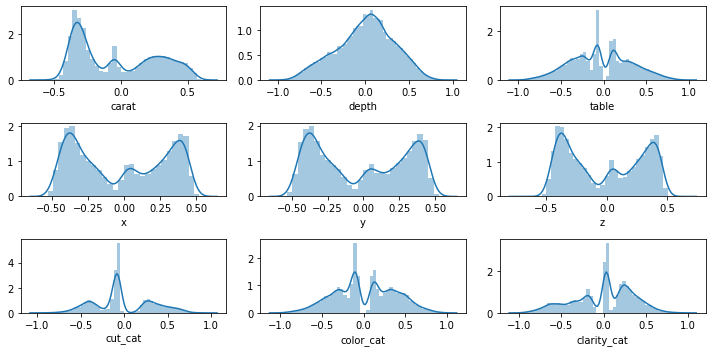

In [195]:
f, ax = plt.subplots(3,3, figsize=(10,5))
for i, e in enumerate(X):
    sns.distplot(X[e], ax = ax[(i//3),(i if i<3 else i-3*(i//3))])
plt.tight_layout()

In [11]:
## Feature selection. 
from sklearn.feature_selection import f_regression
X_new = f_regression(X, y, center=True)

In [12]:
pd.DataFrame(X_new)

,0,1,2,3,4,5,6,7,8
0,265981.05869,6.702488,7.147580e+02,340876.496677,337191.10794,314169.740122,0.216931,2.760229e+02,8.496090e+02
1,0.00000,0.009631,4.900789e-156,0.000000,0.00000,0.000000,0.641391,9.060583e-62,8.968498e-185


### Models

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

Strictly regression models:

In [196]:
models = {
    "LinearRegression" : LinearRegression(),
    "Ridge" : Ridge(alpha=1, tol=0.001, solver='auto', random_state=0),
    "Lasso" : Lasso(alpha=1, max_iter=1000, tol=0.0001),
    "ElasticNet" : ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, tol=0.0001, random_state=0),
    "BayesianRidge": BayesianRidge(n_iter=300, tol=0.001, alpha_1=1e-06, alpha_2=1e-06, lambda_1=1e-06, lambda_2=1e-06)
}

for modelName, model in models.items():
    print(f"Training model: {modelName}")
    model.fit(X_train, y_train)

Training model: LinearRegression
Training model: Ridge
Training model: Lasso
Training model: ElasticNet
Training model: BayesianRidge


Regressors of classification models:

In [14]:
models = {
    "Kneighbors" : KNeighborsRegressor(n_neighbors=10, weights='distance', algorithm='auto', leaf_size=30,),
    "RadiusKneighbors" : RadiusNeighborsRegressor(radius=1.0, weights='distance', algorithm='auto'),
    "GradDescReg" : SGDRegressor(loss='squared_loss', penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, random_state=0),
    "RandForest" : RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=0),
    "DecTreeReg": DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=0)
}

for modelName, model in models.items():
    print(f"Training model: {modelName}")
    model.fit(X_train, y_train)
print('Training done')

Training model: Kneighbors
Training model: RadiusKneighbors
Training model: GradDescReg
Training model: RandForest
Training model: DecTreeReg
Training done


In [223]:
#With original target
for name, model in models.items():
    print(f"---------[{name}]---------:")
    y_pred = model.predict(X_test)
    results = pd.DataFrame({
    "GT":y_test,
    "pred":y_pred,
    "diff":y_pred-y_test
    })
    print("MSE = ",round(mean_squared_error(y_test,y_pred),5))
    print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))
    #display(results)

---------[Kneighbors]---------:
MSE =  579582.42555
RMSE =  761.3031101688126
---------[RadiusKneighbors]---------:
MSE =  2539491.47646
RMSE =  1593.5781990414184
---------[GradDescReg]---------:
MSE =  1686931.52271
RMSE =  1298.8192802330789
---------[RandForest]---------:
MSE =  228793.93043
RMSE =  478.3240851425817
---------[DecTreeReg]---------:
MSE =  478368.71081
RMSE =  691.6420395052529


In [15]:
#With log transformed target
y_test_backtransformed =np.array([math.exp(e) for e in y_test])
for name, model in models.items():
    print(f"---------[{name}]---------:")
    y_pred = model.predict(X_test)
    y_pred_backtransformed =np.array([math.exp(e) for e in y_pred])
    print("MSE = ",round(mean_squared_error(y_test_backtransformed,y_pred_backtransformed),5))
    print("RMSE = ",np.sqrt(mean_squared_error(y_test_backtransformed,y_pred_backtransformed)))
    #display(results)

---------[Kneighbors]---------:
MSE =  566580.65488
RMSE =  752.7155205526109
---------[RadiusKneighbors]---------:
MSE =  2604283.09161
RMSE =  1613.7791334669541
---------[GradDescReg]---------:
MSE =  1556410.13731
RMSE =  1247.5616767570348
---------[RandForest]---------:
MSE =  232547.22632
RMSE =  482.2315069746439
---------[DecTreeReg]---------:
MSE =  463254.68992
RMSE =  680.6281583381113


In [232]:
mod = RandomForestRegressor(n_estimators=200, criterion='mse', max_depth=None, min_samples_split=4, min_samples_leaf=2, random_state=0)
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)
results = pd.DataFrame({
    "GT":y_test,
    "pred":y_pred,
    "diff":y_pred-y_test
    })
print("MSE = ",round(mean_squared_error(y_test,y_pred),5))
print("RMSE = ",np.sqrt(mean_squared_error(y_test,y_pred)))

MSE =  227084.62536
RMSE =  476.53397084041234


In [206]:
parameters = {'n_estimators':[100, 200, 300], 'criterion':('mse', 'mae'),'min_samples_split':[2,3,4,5]}
rndfor = RandomForestRegressor()
rndfor_select = GridSearchCV(rndfor, parameters, verbose=4)
rndfor_select.fit(X_train, y_train)

sorted(rndfor_select.cv_results_.keys())

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] criterion=mse, min_samples_split=2, n_estimators=100 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=mse, min_samples_split=2, n_estimators=100, score=0.979, total=  18.4s
[CV] criterion=mse, min_samples_split=2, n_estimators=100 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.4s remaining:    0.0s


[CV]  criterion=mse, min_samples_split=2, n_estimators=100, score=0.977, total=  18.3s
[CV] criterion=mse, min_samples_split=2, n_estimators=100 ............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   36.7s remaining:    0.0s


[CV]  criterion=mse, min_samples_split=2, n_estimators=100, score=0.979, total=  18.2s
[CV] criterion=mse, min_samples_split=2, n_estimators=100 ............


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   54.8s remaining:    0.0s


[CV]  criterion=mse, min_samples_split=2, n_estimators=100, score=0.978, total=  18.2s
[CV] criterion=mse, min_samples_split=2, n_estimators=100 ............
[CV]  criterion=mse, min_samples_split=2, n_estimators=100, score=0.978, total=  18.2s
[CV] criterion=mse, min_samples_split=2, n_estimators=200 ............
[CV]  criterion=mse, min_samples_split=2, n_estimators=200, score=0.979, total=  36.5s
[CV] criterion=mse, min_samples_split=2, n_estimators=200 ............
[CV]  criterion=mse, min_samples_split=2, n_estimators=200, score=0.977, total=  36.6s
[CV] criterion=mse, min_samples_split=2, n_estimators=200 ............
[CV]  criterion=mse, min_samples_split=2, n_estimators=200, score=0.979, total=  36.4s
[CV] criterion=mse, min_samples_split=2, n_estimators=200 ............
[CV]  criterion=mse, min_samples_split=2, n_estimators=200, score=0.978, total=  36.4s
[CV] criterion=mse, min_samples_split=2, n_estimators=200 ............
[CV]  criterion=mse, min_samples_split=2, n_estimato

[CV]  criterion=mse, min_samples_split=5, n_estimators=300, score=0.979, total=  51.4s
[CV] criterion=mse, min_samples_split=5, n_estimators=300 ............
[CV]  criterion=mse, min_samples_split=5, n_estimators=300, score=0.977, total=  53.3s
[CV] criterion=mse, min_samples_split=5, n_estimators=300 ............
[CV]  criterion=mse, min_samples_split=5, n_estimators=300, score=0.979, total=  51.8s
[CV] criterion=mse, min_samples_split=5, n_estimators=300 ............
[CV]  criterion=mse, min_samples_split=5, n_estimators=300, score=0.978, total=  50.9s
[CV] criterion=mse, min_samples_split=5, n_estimators=300 ............
[CV]  criterion=mse, min_samples_split=5, n_estimators=300, score=0.978, total=  50.9s
[CV] criterion=mae, min_samples_split=2, n_estimators=100 ............
[CV]  criterion=mae, min_samples_split=2, n_estimators=100, score=0.978, total=33.0min
[CV] criterion=mae, min_samples_split=2, n_estimators=100 ............
[CV]  criterion=mae, min_samples_split=2, n_estimato

KeyboardInterrupt: 

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

## Training with all the data:

In [233]:
mod = RandomForestRegressor(n_estimators=200, criterion='mse', max_depth=None, min_samples_split=4, min_samples_leaf=2, random_state=0)
mod.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

### Fixing test data:

In [234]:
clarity = ('IF', 'VVS2','VS1','VS2','SI1','SI2','I1' )
color = ('J', 'I', 'H', 'G', 'F', 'E', 'D')
cut = ('Premium', 'Ideal', 'Very Good', 'Good','Fair')
categories = fn.categorize([test.cut, test.color, test.clarity], [cut, color, clarity])
test_clean = pd.concat([test.drop(['Unnamed: 0', 'cut', 'color', 'clarity'], axis= 1) , categories], axis=1, sort=False )
pipeline = [
    StandardScaler(),
    Normalizer(),
]

tr = make_pipeline(*pipeline)

X_testdata = tr.fit_transform(test_clean)
X_testdata = pd.DataFrame(X_testdata,columns=test_clean.columns)


### Predicting

In [235]:
y_pred = mod.predict(X_testdata)

### Preparing csv

In [236]:
result = pd.DataFrame({'id':X_testdata.index, 'price':y_pred})
result

,id,price
0,0,561.663685
1,1,1363.809433
2,2,9408.648429
3,3,628.367670
4,4,7776.078625
...,...,...
13444,13444,4206.007429
13445,13445,585.987361
13446,13446,13015.645500
13447,13447,8299.200575


In [237]:
result.to_csv('./OUTPUT/submission.csv')